In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import optimizers
from keras import losses

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.utils import plot_model


from IPython.display import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def show_image(image):
    plt.imshow(image)
    plt.show()

In [ ]:
def create_mias_dataset(file_path: str) -> pd.DataFrame:
    ''' Creates a dataset with the data about the scans '''
    # create a dataset
    mammo = pd.read_table(file_path, delimiter='\s', engine='python')
    # rename the class column to avoid conflicts with the class keyword in python
    mammo.columns = ['refnum', 'bg', 'ab_class', 'severity', 'x', 'y', 'radius']
    # fill null severity with A for NORM class
    # mammo.severity = mammo.severity.fillna('A')
    # drop duplicates
    mammo.drop_duplicates(subset='refnum', keep='first', inplace=True)
    # set refnum as index
    # mammo.set_index(keys='refnum', drop=True, inplace=True)

    return mammo

In [ ]:
mias = create_mias_dataset('/content/drive/MyDrive/Dataset/Info.txt')
mias

,refnum,bg,ab_class,severity,x,y,radius
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,None,NaN,NaN,NaN
3,mdb004,D,NORM,None,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0
...,...,...,...,...,...,...,...
325,mdb318,D,NORM,None,NaN,NaN,NaN
326,mdb319,D,NORM,None,NaN,NaN,NaN
327,mdb320,D,NORM,None,NaN,NaN,NaN
328,mdb321,D,NORM,None,NaN,NaN,NaN


In [ ]:
# drop nan in severity which indicate norm 
mias.dropna(subset=['severity'], inplace=True)
mias.reset_index(inplace=True)
mias.drop(['index'],axis=1,inplace=True)
mias

,refnum,bg,ab_class,severity,x,y,radius
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb005,F,CIRC,B,477.0,133.0,30.0
3,mdb010,F,CIRC,B,525.0,425.0,33.0
4,mdb012,F,CIRC,B,471.0,458.0,40.0
...,...,...,...,...,...,...,...
110,mdb274,F,MISC,M,127.0,505.0,123.0
111,mdb290,D,CIRC,B,337.0,353.0,45.0
112,mdb312,F,MISC,B,240.0,263.0,20.0
113,mdb314,F,MISC,B,518.0,191.0,39.0


In [ ]:
# B = 0 index
# M = 1 index
lb = LabelEncoder()
mias['severity'] = lb.fit_transform(mias['severity'])
encoded_labels  = to_categorical(mias['severity'])

In [ ]:
# images path
path= '/content/drive/MyDrive/Dataset/all-mias/'
no_angles = 360

In [ ]:
def read_images_labels():
  # define the every images filepaths in to list
  images = []
  labels=[]

  for i in range(len(mias)):

    image_address= path + mias.refnum[i]+ '.pgm'
    img = cv2.imread(image_address,1)
    img = cv2.resize(img, (224,224))   #resize image
    rows, cols,color = img.shape

    for angle in range(0,no_angles,8):

      M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)    #Rotate 0 degree
      img_rotated = cv2.warpAffine(img, M, (cols, rows))

      images.append(img_rotated)
      labels.append(encoded_labels[i])

  return images, labels

In [ ]:
X, Y = read_images_labels()

In [ ]:
X = np.asarray(X)
X.shape

(5175, 224, 224, 3)

In [ ]:
Y = np.array(Y)
Y.shape

(5175, 2)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=2021,shuffle=True)

In [ ]:
base_model = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(2,activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

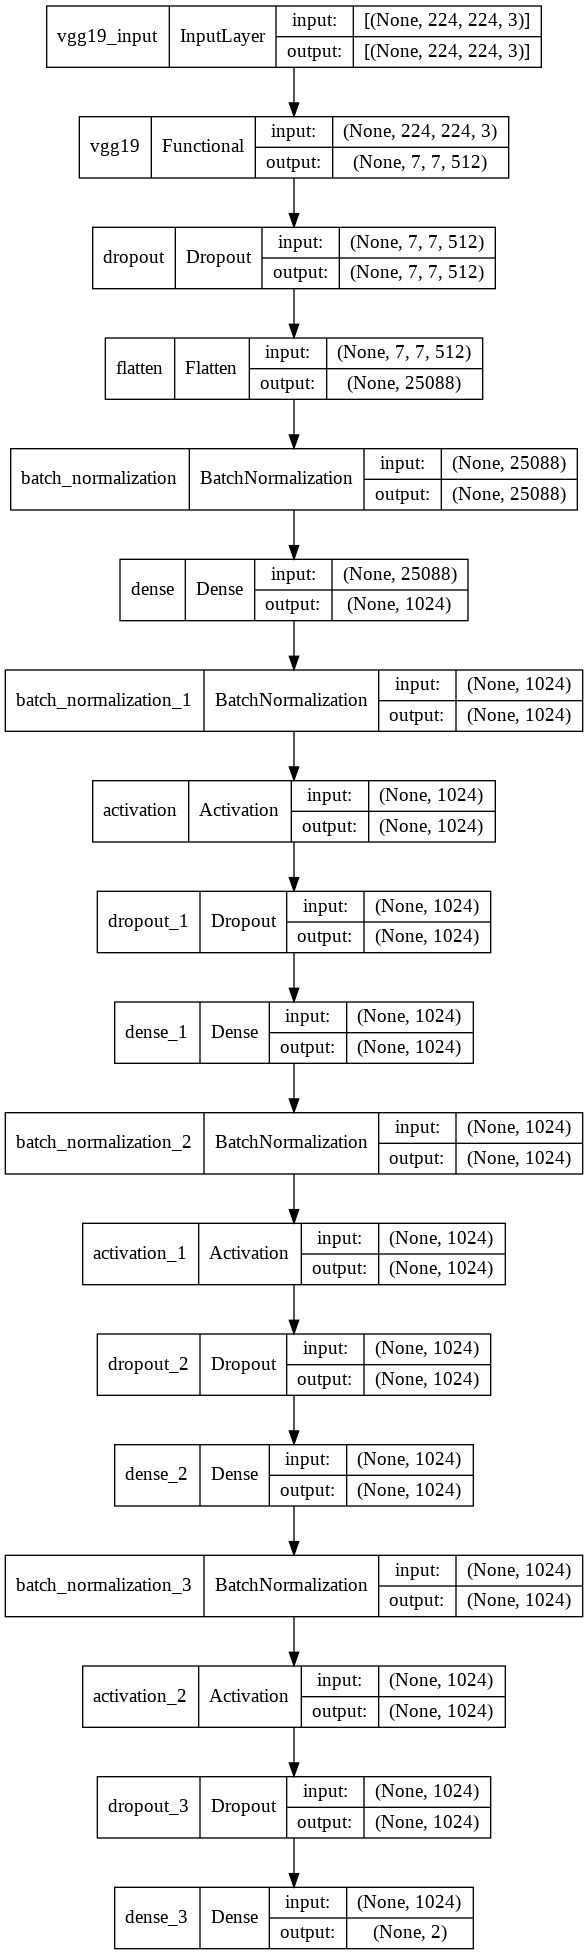

In [ ]:
from tensorflow.keras.utils import model_to_dot 
from IPython.display import Image

plot_model(model, to_file='model_architecture.png' ,show_shapes=True, show_layer_names=True)
Image(filename='model_architecture.png')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=6,restore_best_weights=True, verbose=1)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.15,shuffle=True, epochs=40, batch_size=128,callbacks=[es])

Epoch 1/40
30/30 [==============================] - 98s 2s/step - loss: 0.6227 - accuracy: 0.6851 - val_loss: 1.1243 - val_accuracy: 0.8000
Epoch 2/40
30/30 [==============================] - 37s 1s/step - loss: 0.1343 - accuracy: 0.9559 - val_loss: 0.5463 - val_accuracy: 0.8864
Epoch 3/40
30/30 [==============================] - 37s 1s/step - loss: 0.0418 - accuracy: 0.9850 - val_loss: 0.2933 - val_accuracy: 0.9379
Epoch 4/40
30/30 [==============================] - 37s 1s/step - loss: 0.0549 - accuracy: 0.9802 - val_loss: 0.3626 - val_accuracy: 0.9106
Epoch 5/40
30/30 [==============================] - 37s 1s/step - loss: 0.0494 - accuracy: 0.9813 - val_loss: 0.2608 - val_accuracy: 0.9394
Epoch 6/40
30/30 [==============================] - 37s 1s/step - loss: 0.0482 - accuracy: 0.9848 - val_loss: 0.1719 - val_accuracy: 0.9455
Epoch 7/40
30/30 [==============================] - 37s 1s/step - loss: 0.0449 - accuracy: 0.9853 - val_loss: 0.2035 - val_accuracy: 0.9424
Epoch 8/40
30/30 [==

In [ ]:
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

25/25 [==============================] - 20s 406ms/step - loss: 0.1140 - accuracy: 0.9717
Test_loss_value = 0.11400675028562546
test_accuracy = 0.9716859459877014


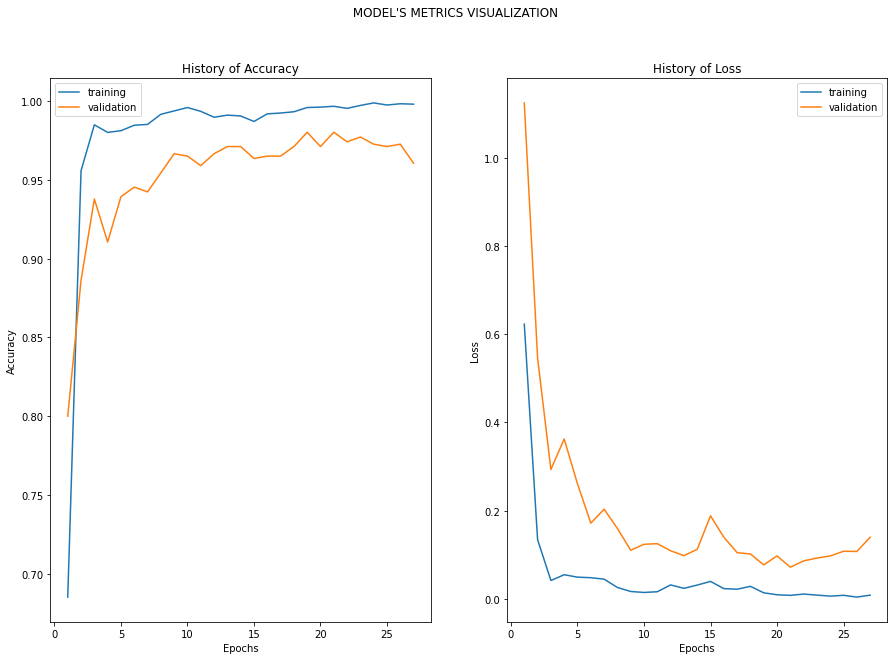

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation)
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [ ]:
predictions = model.predict(x_test)
y_pred = [np.argmax(w) for w in predictions]

In [ ]:
y_test = [np.argmax(w) for w in y_test]

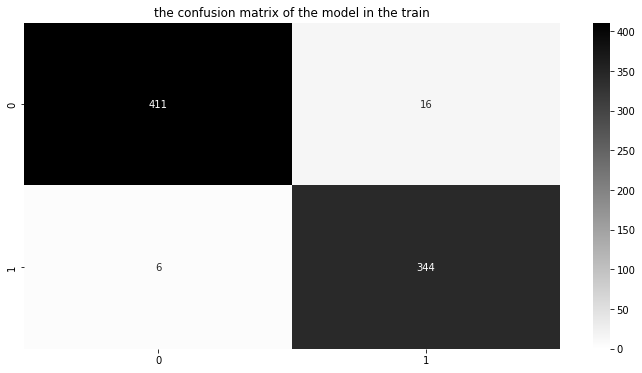

In [ ]:
cm1 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 6))
plt.title('the confusion matrix of the model in the train')
sns.heatmap(cm1, annot = True, fmt = 'g' ,vmin = 0, cmap = 'binary')

In [ ]:
label_mapping = {
    1: 'M',
    0: 'B'
}

classification_report_model = classification_report(y_test, y_pred, target_names=label_mapping.values())
print(classification_report_model)

              precision    recall  f1-score   support

           M       0.99      0.96      0.97       427
           B       0.96      0.98      0.97       350

    accuracy                           0.97       777
   macro avg       0.97      0.97      0.97       777
weighted avg       0.97      0.97      0.97       777



In [ ]:
# tf.saved_model.save(model,'model')
# model.save('Final_model.h5')